Plotting pulses and mixing angle...


<>:545: SyntaxWarning: invalid escape sequence '\l'
<>:623: SyntaxWarning: invalid escape sequence '\d'
<>:625: SyntaxWarning: invalid escape sequence '\O'
<>:545: SyntaxWarning: invalid escape sequence '\l'
<>:623: SyntaxWarning: invalid escape sequence '\d'
<>:625: SyntaxWarning: invalid escape sequence '\O'
C:\Users\pclin\AppData\Local\Temp\ipykernel_1556\1280803562.py:545: SyntaxWarning: invalid escape sequence '\l'
  labels = [f"$\lambda'_{i+1}$" for i in range(8)]
C:\Users\pclin\AppData\Local\Temp\ipykernel_1556\1280803562.py:623: SyntaxWarning: invalid escape sequence '\d'
  plt.xlabel("Two-photon detuning $\delta$ (MHz)")
C:\Users\pclin\AppData\Local\Temp\ipykernel_1556\1280803562.py:625: SyntaxWarning: invalid escape sequence '\O'
  plt.title(f"EIT Transparency Window\n(Control $\Omega_c \\approx$ {Omega_c_mhz:.1f} MHz)")


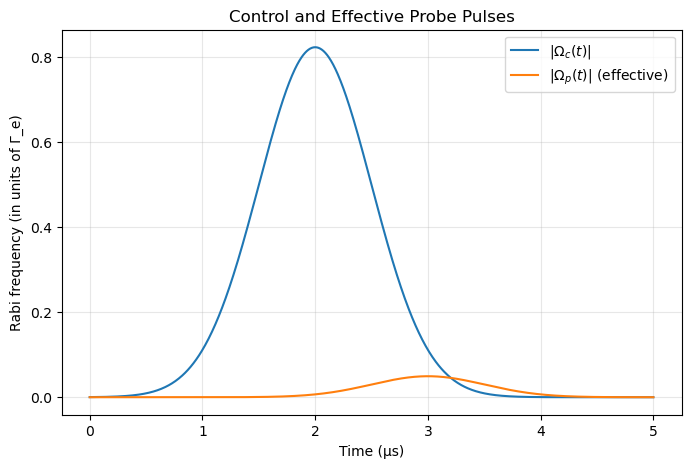

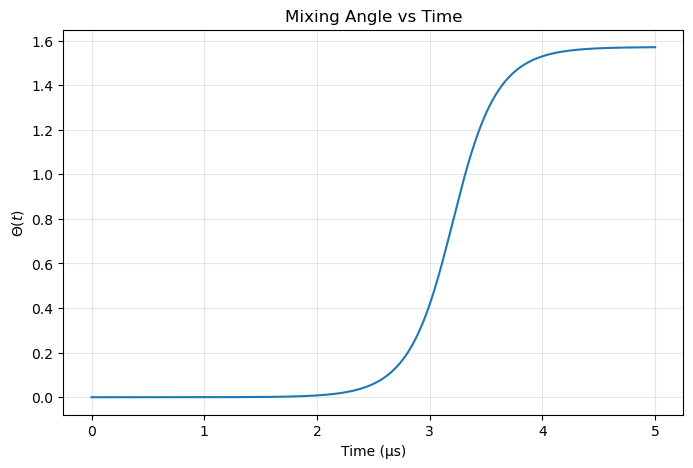

Building physically faithful encoder E_phys (few-mode tripod model)...
Final excited-state population: 4.471e-07
Final excited-state population: 4.471e-07

Encoder matrix E_phys (rows: g-1, g0, g+1; cols: sigma+, sigma-):
[[-0.0686257-0.07955223j  0.       +0.j        ]
 [ 0.       +0.j          0.       +0.j        ]
 [ 0.       +0.j         -0.0686257-0.07955223j]]

Gram matrix G_phys = E_phys^† E_phys:
[[0.01103804+0.j 0.        +0.j]
 [0.        +0.j 0.01103804+0.j]]

Eigenvalues of G_phys (ideal is [η, η] for symmetric encoder):
[0.01103804 0.01103804]

Average storage efficiency eta = Tr(G_phys)/2 = 1.1038e-02

Renormalised isometric encoder E_iso = E_phys / sqrt(eta):
[[-0.65319182-0.75719248j  0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j        ]
 [ 0.        +0.j         -0.65319182-0.75719248j]]

G_iso = E_iso^† E_iso (should be close to identity):
[[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

Eigenvalues of G_iso (ideal is [1, 1]):
[1. 1.]

Running EIT-style diagn

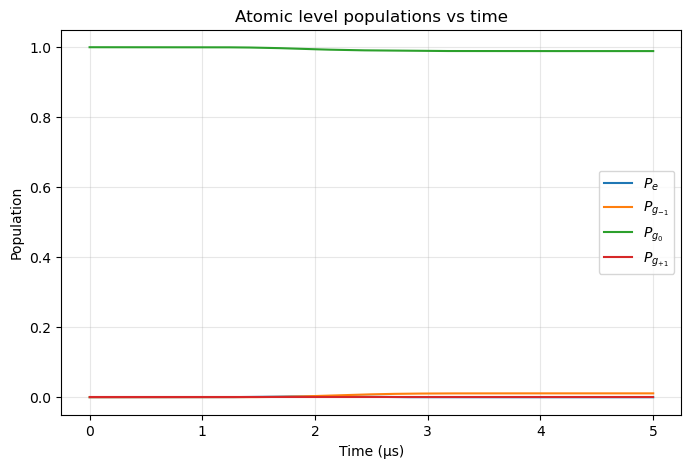

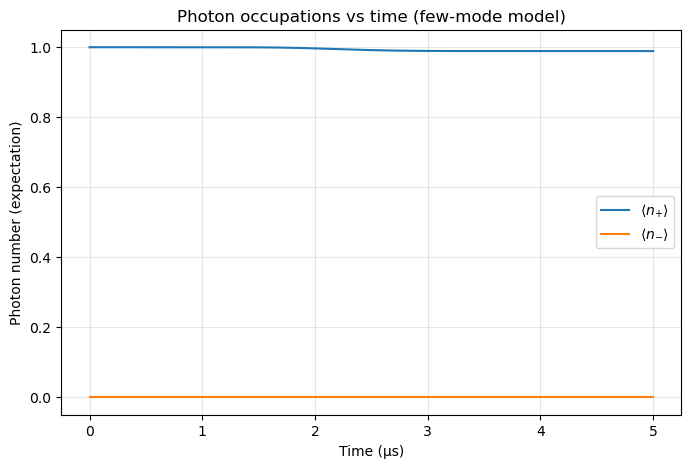

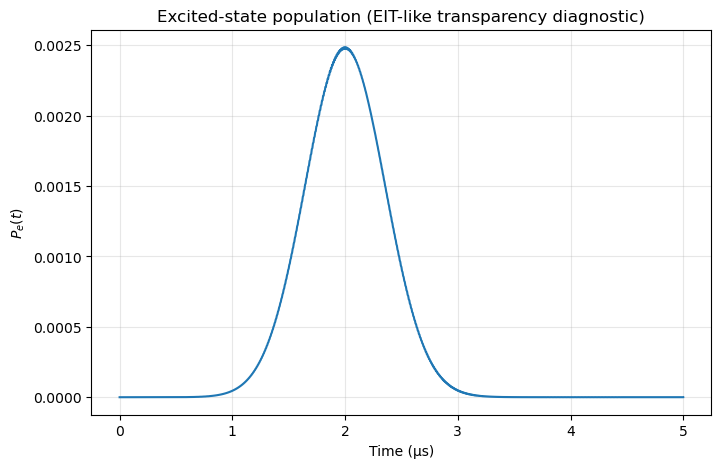


Plotting Adaptive SU(3) Expectations and Leakage Radius...

--- SU(3) Generator Classification (Dark-Adapted Basis) ---
lambda'_1: Leakage (Off-block norm = 1.0000)
lambda'_2: Leakage (Off-block norm = 1.0000)
lambda'_3: Logical (Block A norm = 1.0000)
lambda'_4: Logical (Block A norm = 1.4142)
lambda'_5: Logical (Block A norm = 1.4142)
lambda'_6: Leakage (Off-block norm = 1.0000)
lambda'_7: Leakage (Off-block norm = 1.0000)
lambda'_8: Logical (Block A norm = 1.2910)


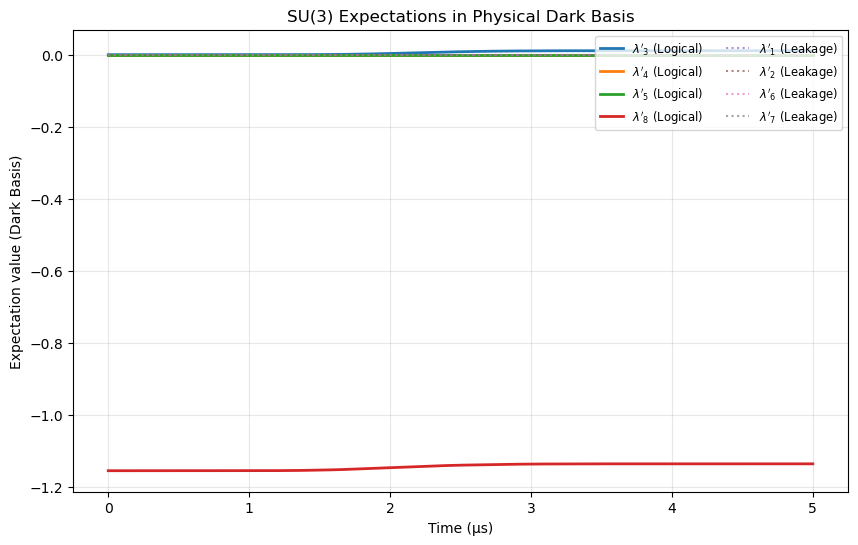

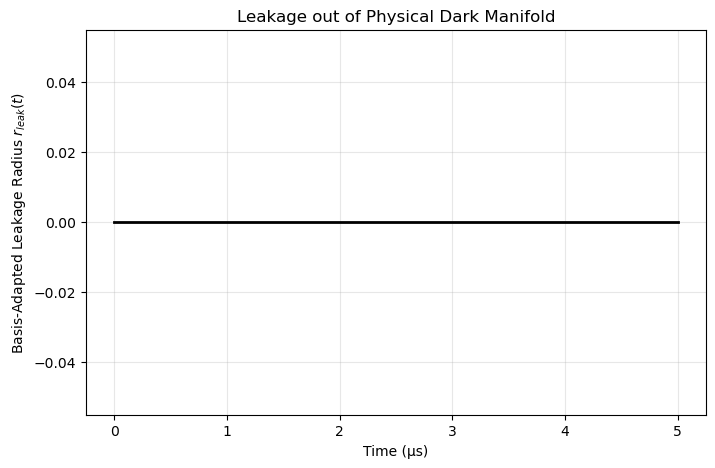


Scanning EIT transparency window (+/- 20.0 MHz)...


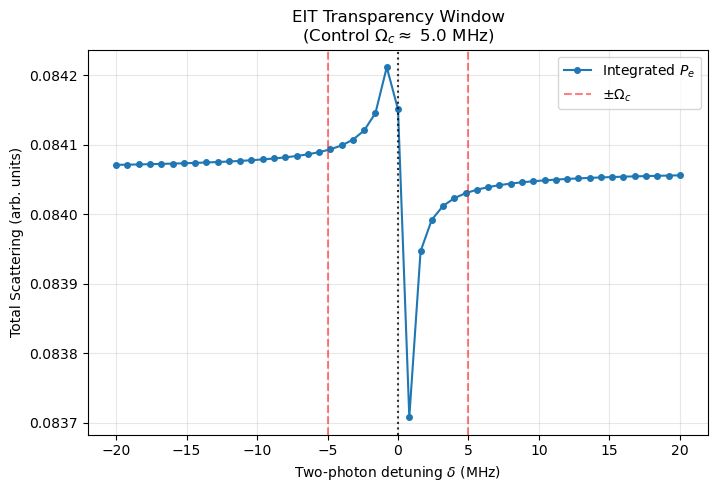

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *

# ------------------------------------------------------------------
# 1. Physical parameters (Rb-87 D2, TQM-SIM-V2 style)
# ------------------------------------------------------------------

# Atomic data
Gamma_e = 2 * np.pi * 6.07e6        # excited-state linewidth (Hz)
Delta_phys = 2 * np.pi * 100e6      # one-photon detuning (Hz), "moderate detuning"

# Control/probe Rabi frequencies (Hz)
Omega_C_phys = 2 * np.pi * 5e6      # control Rabi frequency
Omega_P_phys = 2 * np.pi * 0.3e6    # "typical" probe scale (used to set coupling g)

# Pulse width and total interaction time (s)
sigma_phys   = 0.5e-6               # Gaussian sigma
T_total_phys = 5.0e-6               # write window

# Dimensionless units: t_sim = t_phys * Gamma_e; Omega_sim = Omega_phys / Gamma_e
Gamma = 1.0
Delta    = Delta_phys    / Gamma_e
Omega_c0 = Omega_C_phys / Gamma_e

# Single-photon couplings in units of Gamma_e
g_plus  = Omega_P_phys / Gamma_e
g_minus = Omega_P_phys / Gamma_e

# Time grid (dimensionless)
T_START = 0.0
T_END   = T_total_phys * Gamma_e
N_STEPS = 1001
tlist   = np.linspace(T_START, T_END, N_STEPS)

# Pulse centres (dimensionless; counter-intuitive sequence)
t_c_phys = 2.0e-6     # control pulse centre
t_p_phys = 3.0e-6     # effective probe time-centre (for diagnostics)
t_c   = t_c_phys * Gamma_e
t_p   = t_p_phys * Gamma_e
tau_c = sigma_phys * Gamma_e
tau_p = sigma_phys * Gamma_e

# Ground two-photon detunings (dimensionless) – start with zero
delta_m_phys = np.array([0.0, 0.0, 0.0])  # [delta_-1, delta_0, delta_+1] in Hz
delta_m = delta_m_phys / Gamma_e

# ------------------------------------------------------------------
# 2. Pulse envelopes and mixing angle
# ------------------------------------------------------------------

def Omega_c(t):
    """Control field envelope in units of Gamma_e."""
    return Omega_c0 * np.exp(-(t - t_c)**2 / (2 * tau_c**2))

def Omega_p_eff(t):
    """
    Effective probe scale for plotting/mixing angle.
    The temporal envelope is not used directly in the few-mode Hamiltonian,
    but we keep it for diagnostics to stay consistent with the DSP picture.
    """
    return (Omega_P_phys / Gamma_e) * np.exp(-(t - t_p)**2 / (2 * tau_p**2))

def mixing_angle(t):
    """
    Dark-state mixing angle theta(t) = arctan(|Omega_p| / |Omega_c|).
    Diagnostic only.
    """
    Oc = Omega_c(t)
    Op = Omega_p_eff(t)
    denom = np.sqrt(np.abs(Oc)**2 + np.abs(Op)**2)
    if denom < 1e-12:
        return 0.0
    return np.arctan(np.abs(Op) / np.abs(Oc))

def plot_pulses_and_mixing():
    Oc_vals = np.array([Omega_c(t) for t in tlist])
    Op_vals = np.array([Omega_p_eff(t) for t in tlist])
    theta_vals = np.array([mixing_angle(t) for t in tlist])

    # Time in microseconds for plotting
    t_us = tlist / Gamma_e * 1e6

    plt.figure(figsize=(8, 5))
    plt.plot(t_us, np.abs(Oc_vals), label=r'$|\Omega_c(t)|$')
    plt.plot(t_us, np.abs(Op_vals), label=r'$|\Omega_p(t)|$ (effective)')
    plt.xlabel("Time (µs)")
    plt.ylabel("Rabi frequency (in units of Γ_e)")
    plt.title("Control and Effective Probe Pulses")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    plt.figure(figsize=(8, 5))
    plt.plot(t_us, theta_vals)
    plt.xlabel("Time (µs)")
    plt.ylabel(r'$\Theta(t)$')
    plt.title("Mixing Angle vs Time")
    plt.grid(True, alpha=0.3)
    plt.show()

# ------------------------------------------------------------------
# 3. Hilbert space: atom + σ+ photon + σ- photon
# ------------------------------------------------------------------

# Atom basis: |e>, |g_-1>, |g_0>, |g_+1>
ket_e   = basis(4, 0)
ket_gm1 = basis(4, 1)
ket_g0  = basis(4, 2)
ket_gp1 = basis(4, 3)

P_e   = ket_e   * ket_e.dag()
P_gm1 = ket_gm1 * ket_gm1.dag()
P_g0  = ket_g0  * ket_g0.dag()
P_gp1 = ket_gp1 * ket_gp1.dag()

# Photon Fock dims
N_ph = 2  # support 0,1 photons

# Photon mode operators in full space
a_plus  = tensor(qeye(4), destroy(N_ph), qeye(N_ph))
a_minus = tensor(qeye(4), qeye(N_ph), destroy(N_ph))

# Projectors lifted to atom+photon space
P_e_full    = tensor(P_e,    qeye(N_ph), qeye(N_ph))
P_gm1_full = tensor(P_gm1, qeye(N_ph), qeye(N_ph))
P_g0_full  = tensor(P_g0,  qeye(N_ph), qeye(N_ph))
P_gp1_full = tensor(P_gp1, qeye(N_ph), qeye(N_ph))

# Atomic raising/lowering operators (in full space)
sig_egm1 = tensor(ket_e * ket_gm1.dag(), qeye(N_ph), qeye(N_ph))
sig_eg0  = tensor(ket_e * ket_g0.dag(),  qeye(N_ph), qeye(N_ph))
sig_egp1 = tensor(ket_e * ket_gp1.dag(), qeye(N_ph), qeye(N_ph))

# ------------------------------------------------------------------
# 4. Time-dependent Hamiltonian for the few-mode tripod
# ------------------------------------------------------------------

def H_tripod_t(t, args):
    """
    Full Hamiltonian H(t)/ħ in dimensionless units (frequencies scaled by Γ_e).

    Includes:
      - excited state detuning -Delta |e><e|
      - ground two-photon detunings delta_m
      - couplings:
          g_minus a_plus |e><g_-1| + h.c.
          g_plus  a_minus|e><g_+1| + h.c.
          Omega_c(t) |e><g_0| + h.c.
    """
    delta = args.get("delta_m", delta_m)

    # Diagonal detunings
    H = (-Delta) * P_e_full
    H += delta[0] * P_gm1_full
    H += delta[1] * P_g0_full
    H += delta[2] * P_gp1_full

    # σ+ coupling: |g_-1;1_+> ↔ |e;0_+>
    H += g_minus * (a_plus * sig_egm1.dag() + a_plus.dag() * sig_egm1)

    # σ- coupling: |g_+1;1_-> ↔ |e;0_->
    H += g_plus * (a_minus * sig_egp1.dag() + a_minus.dag() * sig_egp1)

    # Control field coupling (classical) |g_0> ↔ |e>
    Oc = Omega_c(t)
    H += Oc * sig_eg0 + np.conj(Oc) * sig_eg0.dag()

    return H

# ------------------------------------------------------------------
# 5. Initial states: photonic σ+, σ− and atomic |g0>
# ------------------------------------------------------------------

# Photon Fock basis: |n_+>, |n_->
ket_0_plus  = basis(N_ph, 0)
ket_1_plus  = basis(N_ph, 1)
ket_0_minus = basis(N_ph, 0)
ket_1_minus = basis(N_ph, 1)

# Single-photon circular polarisations
ket_sigma_plus  = tensor(ket_1_plus, ket_0_minus)   # one σ+ photon
ket_sigma_minus = tensor(ket_0_plus, ket_1_minus)   # one σ- photon

# Atomic initial state |g0>
psi_atom0 = ket_g0

# Full initial states
psi_in_sigma_plus  = tensor(psi_atom0, ket_1_plus, ket_0_minus)
psi_in_sigma_minus = tensor(psi_atom0, ket_0_plus, ket_1_minus)

# ------------------------------------------------------------------
# 6. Encoder Construction (physical + renormalised)
# ------------------------------------------------------------------

def evolve_and_extract(alpha_plus, alpha_minus, do_log=False):
    """
    Evolve a single tripod atom + 2 photonic modes for a given input
    photonic polarisation (alpha_plus, alpha_minus) and return the
    3-component ground-state vector c = (c_{-1}, c_0, c_{+1}).

    This uses the full few-mode Hamiltonian and projects onto the
    atomic ground manifold at t = T_end.
    """
    # Normalise input
    norm = np.sqrt(abs(alpha_plus)**2 + abs(alpha_minus)**2)
    if norm < 1e-12:
        raise ValueError("Input photonic state has zero norm.")
    ap = alpha_plus / norm
    am = alpha_minus / norm

    # Initial state: |1_photon_in_polarisation> ⊗ |g_0>
    psi_in = ap * psi_in_sigma_plus + am * psi_in_sigma_minus

    # No collapse operators for now (purely coherent; gamma=0 for few-mode Sim)
    c_ops = []

    # Time evolution
    res = mesolve(
        H_tripod_t,
        psi_in,
        tlist,
        c_ops,
        e_ops=[],
        args={"delta_m": delta_m},
    )

    psi_T = res.states[-1]

    # Optional diagnostic: check excited-state population at final time
    if do_log:
        rho_full = ket2dm(psi_T)
        pop_e_final = (P_e_full * rho_full).tr().real
        print(f"Final excited-state population: {pop_e_final:.3e}")

    # Extract complex amplitudes of atomic ground states from psi_T
    # We use direct projection to preserve phase relative to the defined basis
    amp_gm1 = (tensor(ket_gm1.dag(), qeye(N_ph), qeye(N_ph)) * psi_T).full()[0, 0]
    amp_g0  = (tensor(ket_g0.dag(),  qeye(N_ph), qeye(N_ph)) * psi_T).full()[0, 0]
    amp_gp1 = (tensor(ket_gp1.dag(), qeye(N_ph), qeye(N_ph)) * psi_T).full()[0, 0]

    c_vec = np.array([amp_gm1, amp_g0, amp_gp1], dtype=complex)
    return c_vec


def build_encoder():
    """
    Construct both:
      - E_phys: the 3x2 physical encoder (includes absolute efficiency)
      - E_iso:  the 3x2 renormalised encoder with G_iso ≈ I (isometric)

    Returns:
      E_phys, E_iso, eta, G_phys, G_iso, eigvals_G_phys, eigvals_G_iso
    """
    print("Building physically faithful encoder E_phys (few-mode tripod model)...")

    # Columns for input |σ+> and |σ-> polarisations
    c_sigma_plus  = evolve_and_extract(1.0, 0.0, do_log=True)   # σ+
    c_sigma_minus = evolve_and_extract(0.0, 1.0, do_log=True)   # σ-

    # Stack into a 3x2 matrix: rows = (g_-1, g_0, g_+1), cols = (σ+, σ-)
    E_phys = np.column_stack((c_sigma_plus, c_sigma_minus))

    # Physical Gram matrix G_phys = E_phys^† E_phys
    G_phys = E_phys.conj().T @ E_phys
    eigvals_G_phys = np.linalg.eigvalsh(G_phys)

    # Average storage efficiency over σ+ and σ−:
    # eta = mean(||E_phys e_i||^2) = Tr(G_phys)/2
    eta = 0.5 * np.trace(G_phys).real

    # Renormalised (isometric) encoder
    if eta > 1e-12:
        scale = np.sqrt(eta)
        E_iso = E_phys / scale
        G_iso = E_iso.conj().T @ E_iso
        eigvals_G_iso = np.linalg.eigvalsh(G_iso)
    else:
        E_iso = np.zeros_like(E_phys)
        G_iso = np.zeros((2, 2), dtype=complex)
        eigvals_G_iso = np.array([0.0, 0.0])

    # ---- Logging ----
    print("\nEncoder matrix E_phys (rows: g-1, g0, g+1; cols: sigma+, sigma-):")
    print(E_phys)

    print("\nGram matrix G_phys = E_phys^† E_phys:")
    print(G_phys)
    print("\nEigenvalues of G_phys (ideal is [η, η] for symmetric encoder):")
    print(eigvals_G_phys)
    print(f"\nAverage storage efficiency eta = Tr(G_phys)/2 = {eta:.4e}")

    print("\nRenormalised isometric encoder E_iso = E_phys / sqrt(eta):")
    print(E_iso)

    print("\nG_iso = E_iso^† E_iso (should be close to identity):")
    print(G_iso)
    print("\nEigenvalues of G_iso (ideal is [1, 1]):")
    print(eigvals_G_iso)

    return E_phys, E_iso, eta, G_phys, G_iso, eigvals_G_phys, eigvals_G_iso

# ------------------------------------------------------------------
# 7. EIT-like diagnostics: populations vs time
# ------------------------------------------------------------------

# Photon number operators in full space
N_plus_full  = tensor(qeye(4), num(N_ph), qeye(N_ph))
N_minus_full = tensor(qeye(4), qeye(N_ph), num(N_ph))

def run_trajectory(alpha_plus=1.0, alpha_minus=0.0):
    """
    Evolve the few-mode tripod for a given input photonic polarisation.
    Returns the mesolve result object so we can inspect populations, etc.
    """
    # Normalise input
    norm = np.sqrt(abs(alpha_plus)**2 + abs(alpha_minus)**2)
    if norm < 1e-12:
        raise ValueError("Input photonic state has zero norm.")
    ap = alpha_plus / norm
    am = alpha_minus / norm

    psi_in = ap * psi_in_sigma_plus + am * psi_in_sigma_minus

    res = mesolve(
        H_tripod_t,
        psi_in,
        tlist,
        c_ops=[],
        e_ops=[],
        args={"delta_m": delta_m},
    )
    return res


def plot_eit_and_populations(alpha_plus=1.0, alpha_minus=0.0):
    """
    Plot populations and photon numbers.
    """
    res = run_trajectory(alpha_plus, alpha_minus)

    # Populations in atomic levels
    pop_e   = expect(P_e_full,   res.states)
    pop_gm1 = expect(P_gm1_full, res.states)
    pop_g0  = expect(P_g0_full,  res.states)
    pop_gp1 = expect(P_gp1_full, res.states)

    # Photon numbers
    n_plus  = expect(N_plus_full,  res.states)
    n_minus = expect(N_minus_full, res.states)

    t_us = tlist / Gamma_e * 1e6

    # (1) Atomic populations
    plt.figure(figsize=(8, 5))
    plt.plot(t_us, pop_e,   label=r'$P_e$')
    plt.plot(t_us, pop_gm1, label=r'$P_{g_{-1}}$')
    plt.plot(t_us, pop_g0,  label=r'$P_{g_0}$')
    plt.plot(t_us, pop_gp1, label=r'$P_{g_{+1}}$')
    plt.xlabel("Time (µs)")
    plt.ylabel("Population")
    plt.title("Atomic level populations vs time")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # (2) Photon numbers and “stored fraction”
    plt.figure(figsize=(8, 5))
    plt.plot(t_us, n_plus,  label=r'$\langle n_{+}\rangle$')
    plt.plot(t_us, n_minus, label=r'$\langle n_{-}\rangle$')
    plt.xlabel("Time (µs)")
    plt.ylabel("Photon number (expectation)")
    plt.title("Photon occupations vs time (few-mode model)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    # (3) Excited-state population as “EIT transparency” proxy
    plt.figure(figsize=(8, 5))
    plt.plot(t_us, pop_e)
    plt.xlabel("Time (µs)")
    plt.ylabel(r'$P_e(t)$')
    plt.title("Excited-state population (EIT-like transparency diagnostic)")
    plt.grid(True, alpha=0.3)
    plt.show()

# ------------------------------------------------------------------
# 8. SU(3) utility functions (BARE BASIS)
# ------------------------------------------------------------------

def su3_generators_bare_3x3():
    """
    Return 8 Gell-Mann matrices acting on the 3D ground manifold 
    in the bare basis {|g_-1>, |g_0>, |g_+1>}.
    """
    λ1 = np.array([[0,1,0],[1,0,0],[0,0,0]], dtype=complex)
    λ2 = np.array([[0,-1j,0],[1j,0,0],[0,0,0]], dtype=complex)
    λ3 = np.array([[1,0,0],[0,-1,0],[0,0,0]], dtype=complex)
    λ4 = np.array([[0,0,1],[0,0,0],[1,0,0]], dtype=complex)
    λ5 = np.array([[0,0,-1j],[0,0,0],[1j,0,0]], dtype=complex)
    λ6 = np.array([[0,0,0],[0,0,1],[0,1,0]], dtype=complex)
    λ7 = np.array([[0,0,0],[0,0,-1j],[0,1j,0]], dtype=complex)
    λ8 = (1/np.sqrt(3)) * np.array([[1,0,0],[0,1,0],[0,0,-2]], dtype=complex)
    return [λ1, λ2, λ3, λ4, λ5, λ6, λ7, λ8]

# ------------------------------------------------------------------
# 9. SU(3) Basis Adaptation: Dark Space & Leakage
# ------------------------------------------------------------------

def get_dark_basis_unitary(E_phys):
    """
    Construct the transformation U that maps the standard SU(3) basis
    to the Dark/Bright basis determined by the Physical Encoder.
    
    Logic:
    1. E_phys columns span the actual Dark Manifold used in storage.
    2. QR Decomposition of E_phys gives orthonormal basis |D0>, |D1> (columns of Q).
    3. Since E_phys is 3x2, QR (mode='complete') yields Q (3x3), where
       the 3rd column is automatically |B> (orthogonal to D0, D1).
    
    Returns:
        U_atom (3x3 numpy array): [ |D0>  |D1>  |B> ]
    """
    # QR decomposition of the 3x2 encoder.
    # 'complete' gives us Q as 3x3, automatically completing the basis.
    Q, R = np.linalg.qr(E_phys, mode='complete')
    
    # Q columns: 0->|D0>, 1->|D1>, 2->|B>
    # This Q is precisely the unitary U that maps:
    #   Basis vector (1,0,0) -> |D0>
    #   Basis vector (0,1,0) -> |D1>
    #   Basis vector (0,0,1) -> |B>
    return Q

def transform_and_classify_su3(U_atom):
    """
    Rotate the 8 bare Gell-Mann matrices into the Dark-Adapted basis defined by U_atom.
    Identify which are 'Logical' (act on D subspace) vs 'Leakage' (mix D and B).
    
    Returns:
        su3_rotated (list of 8 matrices)
        leakage_indices (list of ints)
        logical_indices (list of ints)
    """
    bare_gen = su3_generators_bare_3x3()
    rotated_gen = []
    
    leakage_indices = []
    logical_indices = []
    
    print("\n--- SU(3) Generator Classification (Dark-Adapted Basis) ---")
    
    for i, lam in enumerate(bare_gen):
        # Rotate: lam' = U^dag * lam * U
        lam_prime = U_atom.conj().T @ lam @ U_atom

        # Check Hermiticity
        herm_check = np.linalg.norm(lam_prime - lam_prime.conj().T)
        if herm_check > 1e-10:
            print(f"WARNING: lambda'_{i+1} lost Hermiticity! Norm(H - H^dag) = {herm_check:.2e}")

        rotated_gen.append(lam_prime)
        
        # Analyze structure
        # Block decomposition:
        # [ A (2x2)   b (2x1) ]
        # [ b^dag     c (1x1) ]
        
        block_A = lam_prime[0:2, 0:2]
        block_b = lam_prime[0:2, 2]
        
        norm_A = np.linalg.norm(block_A)
        norm_b = np.linalg.norm(block_b)
        
        # Threshold for classification
        tol = 1e-6
        
        is_leakage = norm_b > tol
        is_logical = (not is_leakage) and (norm_A > tol)
        
        idx = i + 1 # 1-based index for display
        
        if is_leakage:
            leakage_indices.append(i)
            print(f"lambda'_{idx}: Leakage (Off-block norm = {norm_b:.4f})")
        elif is_logical:
            logical_indices.append(i)
            print(f"lambda'_{idx}: Logical (Block A norm = {norm_A:.4f})")
        else:
            print(f"lambda'_{idx}: Auxiliary/Bright (Acts primarily on |B>)")
            
    return rotated_gen, leakage_indices, logical_indices

def get_full_space_operators(su3_atomic_matrices):
    """
    Lift 3x3 atomic matrices (ground manifold) to full 4x4 (atom) x N_ph x N_ph space.
    """
    ops_full = []
    for op3 in su3_atomic_matrices:
        # Embed 3x3 into 4x4 atomic space (row/col 0 is |e>, 0s)
        op4 = np.zeros((4,4), dtype=complex)
        op4[1:, 1:] = op3
        
        # Tensor with photon identity
        q_op = tensor(Qobj(op4), qeye(N_ph), qeye(N_ph))
        ops_full.append(q_op)
    return ops_full


def plot_su3_expectations(E_phys, alpha_plus=1.0, alpha_minus=0.0):
    """
    Plot expectation values of SU(3) generators transformed into the 
    dark-adapted basis determined by E_phys.
    
    Calculates r_leak(t) using the ALGEBRAICALLY identified leakage generators.
    """
    # 1. Get basis transformation from physical encoder
    U_atom = get_dark_basis_unitary(E_phys)
    
    # 2. Get transformed generators and classify them
    rotated_matrices, leak_idxs, log_idxs = transform_and_classify_su3(U_atom)
    
    # 3. Lift to full Hilbert space for simulation
    # We measure the ROTATED observables on the state.
    # expectation(lambda') = <psi | U^dag lambda U | psi>
    # This is equivalent to rotating the state, but we rotate operators here.
    ops_full = get_full_space_operators(rotated_matrices)
    
    # 4. Run dynamics
    res = run_trajectory(alpha_plus, alpha_minus)
    
    # 5. Compute expectations
    exps = [expect(op, res.states) for op in ops_full]
    t_us = tlist / Gamma_e * 1e6
    
    # 6. Compute Basis-Agnostic Leakage Radius
    # r_leak = sqrt( sum( <lambda'_leak>^2 ) )
    leakage_sq_sum = np.zeros_like(t_us)
    for idx in leak_idxs:
        leakage_sq_sum += exps[idx]**2
    r_leak = np.sqrt(leakage_sq_sum)

    # --- PLOTTING ---
    
    labels = [f"$\lambda'_{i+1}$" for i in range(8)]
    
    plt.figure(figsize=(10, 6))
    
    # Plot Logical
    for i in log_idxs:
        plt.plot(t_us, exps[i], linestyle='-', linewidth=2, 
                 label=f"{labels[i]} (Logical)")
        
    # Plot Leakage
    for i in leak_idxs:
        plt.plot(t_us, exps[i], linestyle=':', linewidth=1.5, alpha=0.7,
                 label=f"{labels[i]} (Leakage)")

    plt.xlabel("Time (µs)")
    plt.ylabel("Expectation value (Dark Basis)")
    plt.title("SU(3) Expectations in Physical Dark Basis")
    plt.legend(ncol=2, fontsize='small', loc='upper right')
    plt.grid(True, alpha=0.3)
    plt.show()

    # Plot Leakage Radius
    plt.figure(figsize=(8, 5))
    plt.plot(t_us, r_leak, 'k-', linewidth=2)
    plt.xlabel("Time (µs)")
    plt.ylabel(r"Basis-Adapted Leakage Radius $r_{leak}(t)$")
    plt.title("Leakage out of Physical Dark Manifold")
    plt.grid(True, alpha=0.3)
    plt.show()

# ------------------------------------------------------------------
# 11. Spectral Scan: EIT Transparency Window
# ------------------------------------------------------------------

def scan_transparency_window(scan_range_mhz=15.0, n_points=41):
    """
    Scan the two-photon detuning 'delta' of the probe field relative
    to the control field and measure total scattering.
    """
    print(f"\nScanning EIT transparency window (+/- {scan_range_mhz} MHz)...")

    # Convert scan range to dimensionless units (relative to Gamma_e)
    range_dimless = (2 * np.pi * scan_range_mhz * 1e6) / Gamma_e
    deltas = np.linspace(-range_dimless, range_dimless, n_points)
    
    integrated_Pe = []
    
    # Use a standard input state (e.g. sigma+)
    norm = 1.0
    psi_in = psi_in_sigma_plus # pure sigma+ input

    for d in deltas:
        current_delta_m = np.array([d, 0.0, d])
        
        res = mesolve(
            H_tripod_t,
            psi_in,
            tlist,
            c_ops=[],
            e_ops=[P_e_full], 
            args={"delta_m": current_delta_m},
            options=Options(store_states=False) 
        )
        
        total_scat = np.trapz(res.expect[0], tlist)
        integrated_Pe.append(total_scat)

    integrated_Pe = np.array(integrated_Pe)
    deltas_mhz = deltas * Gamma_e / (2 * np.pi * 1e6)

    plt.figure(figsize=(8, 5))
    plt.plot(deltas_mhz, integrated_Pe, 'o-', markersize=4, label='Integrated $P_e$')
    
    Omega_c_mhz = Omega_C_phys / (2 * np.pi * 1e6)
    plt.axvline(x=-Omega_c_mhz, color='r', linestyle='--', alpha=0.5, label=r'$\pm \Omega_c$')
    plt.axvline(x=Omega_c_mhz,  color='r', linestyle='--', alpha=0.5)
    plt.axvline(x=0, color='k', linestyle=':', alpha=0.8)

    plt.xlabel("Two-photon detuning $\delta$ (MHz)")
    plt.ylabel("Total Scattering (arb. units)")
    plt.title(f"EIT Transparency Window\n(Control $\Omega_c \\approx$ {Omega_c_mhz:.1f} MHz)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


# ------------------------------------------------------------------
# 12. Main
# ------------------------------------------------------------------

if __name__ == "__main__":
    print("Plotting pulses and mixing angle...")
    plot_pulses_and_mixing()

    # Build encoder (physical + renormalised)
    E_phys, E_iso, eta, G_phys, G_iso, eig_G_phys, eig_G_iso = build_encoder()

    print("\nRunning EIT-style diagnostics for input σ+ ...")
    plot_eit_and_populations(alpha_plus=1.0, alpha_minus=0.0)

    print("\nPlotting Adaptive SU(3) Expectations and Leakage Radius...")
    # Pass E_phys so we can construct the Dark Basis U
    plot_su3_expectations(E_phys, alpha_plus=1.0, alpha_minus=0.0)

    # Scan
    scan_transparency_window(scan_range_mhz=20.0, n_points=51)